## Convert coco to Yolo

In [26]:
from ultralytics.data.converter import convert_coco
labels_dir= "C:/Users/kimin/HSC/dataset/dataset/val/"
save_dir = "C:/Users/kimin/HSC/dataset/dataset/val/labels/"
convert_coco(labels_dir, save_dir, use_segments=False)

Annotations C:\Users\kimin\HSC\dataset\dataset\val\val.json: 100%|██████████| 1957/1957 [00:01<00:00, 1635.06it/s]

COCO data converted successfully.
Results saved to C:\Users\kimin\HSC\dataset\dataset\val\labels


### Find missing files

In [ ]:
import os
import shutil

# 두 폴더의 경로를 지정합니다.
folder_1 = "C:/Users/kimin/HSC/dataset/train/images"  # 이미지 파일이 있는 폴더 경로
folder_2 = "C:/Users/kimin/HSC/dataset/train/labels"  # txt 파일이 있는 폴더 경로
destination_folder = "C:/Users/kimin/HSC/dataset/train/"

# 새로운 폴더 생성 (존재하지 않으면 생성)
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)


# 이미지 폴더에서 파일 목록을 가져옴 (확장자 제외)
image_files = {os.path.splitext(file)[0]: file for file in os.listdir(folder_1) if file.endswith('.png')}

# txt 폴더에서 파일 목록을 가져옴 (확장자 제외)
txt_files = {os.path.splitext(file)[0] for file in os.listdir(folder_2)}

# txt 폴더에 없는 이미지 파일 찾기
missing_files = [image_files[file] for file in image_files if file not in txt_files]

# 파일 복사
for file in missing_files:
    source_path = os.path.join(folder_1, file)
    destination_path = os.path.join(destination_folder, file)
    shutil.copy(source_path, destination_path)

#print(f"{len(missing_files)}개의 파일이 {destination_folder}에 복사되었습니다.")

# 결과 출력
print(f"txt 폴더에 없는 파일 수: {len(missing_files)}")
for file in sorted(missing_files):
    print(file)



## Train with YOLO version 8 

In [2]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.2.2+cu121 (NVIDIA GeForce RTX 4070)


### 1. Creat Yaml file

In [15]:
import yaml

def load_yaml(file_path):
    with open(file_path, 'r') as file:
        data = yaml.safe_load(file)
    return data

# 파일 경로
file_path = "C:/Users/kimin/HSC/dataset/dataset.yaml"

# YAML 파일 로드
data = load_yaml(file_path)

# 데이터 출력
print(data)

{'train': '../train/images', 'val': '../val/images', 'test': '../test/images', 'names': ['person', 'car', 'truck', 'bus', 'bicycle', 'bike', 'extra_veichle', 'dog'], 'nc': 8}


In [28]:
# train folder, test folder 생성 확인
from glob import glob

"""
train_img_list = glob('C:/Users/kimin/YOLO/dataset/train/images/*.png')
train_txt_list = glob('C:/Users/kimin/YOLO/dataset/train/labels/*.txt')
#test_img_list = glob('C:/Users/kimin/YOLO/dataset/test/images/*.png')
#test_txt_list = glob('C:/Users/kimin/YOLO/dataset/test/labels/*.txt')
valid_img_list = glob('C:/Users/kimin/YOLO/dataset/val/images/*.png')
valid_txt_list = glob('C:/Users/kimin/YOLO/dataset/val/labels/*.txt')

"""

train_img_list = glob('C:/Users/kimin/HSC/dataset/dataset/train/images/*.png') + glob('C:/Users/kimin/HSC/dataset/dataset/train/images/*.jpeg')
train_txt_list = glob('C:/Users/kimin/HSC/dataset/dataset/train/labels/*.txt')
#test_img_list = glob('C:/Users/kimin/HSC/dataset/dataset/test/images/*.png')
#test_txt_list = glob('C:/Users/kimin/HSC/dataset/dataset/test/labels/*.txt')
valid_img_list = glob('C:/Users/kimin/HSC/dataset/dataset/val/images/*.png') + glob('C:/Users/kimin/HSC/dataset/dataset/val/images/*.jpeg')
valid_txt_list = glob('C:/Users/kimin/HSC/dataset/dataset/val/labels/*.txt')



print(len(train_img_list), len(valid_img_list))
print(len(train_txt_list), len(valid_txt_list))

15880 1966
14755 1957


In [29]:
# file read
with open('C:/Users/kimin/YOLO/dataset/text file/train.txt', 'w') as f:
    f.write('\n'.join(train_img_list) + '\n')

with open('C:/Users/kimin/YOLO/dataset/text file/val.txt', 'w') as f:
    f.write('\n'.join(valid_img_list) + '\n')

In [30]:
import yaml

with open('C:/Users/kimin/YOLO/dataset/text file/dataset.yaml', 'r') as f:
    data = yaml.safe_load(f)

print(data)

data['train'] = 'C:/Users/kimin/YOLO/dataset/text file/train.txt'
data['val'] = 'C:/Users/kimin/YOLO/dataset/text file/val.txt'

with open('C:/Users/kimin/YOLO/dataset/text file/dataset.yaml', 'w') as f:
    yaml.dump(data, f)

print(data)

{'names': ['person', 'car', 'truck', 'bus', 'bicycle', 'bike', 'extra_veichle', 'dog'], 'nc': 8, 'test': '../test/images', 'train': 'C:/Users/kimin/YOLO/dataset/train_augmented.txt', 'val': 'C:/Users/kimin/YOLO/dataset/val.txt'}
{'names': ['person', 'car', 'truck', 'bus', 'bicycle', 'bike', 'extra_veichle', 'dog'], 'nc': 8, 'test': '../test/images', 'train': 'C:/Users/kimin/YOLO/dataset/text file/train.txt', 'val': 'C:/Users/kimin/YOLO/dataset/text file/val.txt'}


### 2. Detection Part

In [6]:
#Check the YOLO version
import ultralytics

ultralytics.checks()

Ultralytics YOLOv8.2.92  Python-3.8.19 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
Setup complete  (20 CPUs, 31.8 GB RAM, 498.0/930.6 GB disk)


In [35]:
import random
import os
from ultralytics import YOLO
from PIL import Image
from blur import process_image_with_blur_and_noise  # blur.py에서 Gaussian 블러와 노이즈 함수 가져오기

# YOLO 모델 로드
model = YOLO("C:/Users/kimin/YOLO/yolov8s.pt")

"""
# 데이터셋 디렉토리 설정
dataset_dir = 'C:/Users/kimin/YOLO/dataset/train/images'  # 원본 이미지 데이터셋 경로
processed_dir = 'C:/Users/kimin/YOLO/dataset/train/processed_images'  # 블러 및 노이즈 처리가 된 이미지를 저장할 디렉토리
train_txt_path = 'C:/Users/kimin/YOLO/dataset/train.txt'  # train.txt 파일 경로
new_train_txt_path = 'C:/Users/kimin/YOLO/dataset/train_augmented.txt'  # 새롭게 생성할 train 파일 경로
"""

# 데이터셋 디렉토리 설정
dataset_dir = 'C:/Users/kimin/HSC/dataset/dataset/train/images'  # 원본 이미지 데이터셋 경로
processed_dir = 'C:/Users/kimin/HSC/dataset/dataset/train/processed_images'  # 블러 및 노이즈 처리가 된 이미지를 저장할 디렉토리
train_txt_path = 'C:/Users/kimin/YOLO/dataset/text file/train.txt'  # train.txt 파일 경로
new_train_txt_path = 'C:/Users/kimin/YOLO/dataset/text file/train_augmented.txt'  # 새롭게 생성할 train 파일 경로

# 데이터셋에서 이미지 파일 가져오기
image_files = [f for f in os.listdir(dataset_dir) if f.endswith('.jpg') or f.endswith('.png')]

# 데이터셋의 10% 랜덤 선택
num_images = len(image_files)
num_to_process = int(num_images * 0.1)  # 전체 이미지 중 10%만 처리
selected_images = random.sample(image_files, num_to_process)

# Blur와 Noise 처리를 적용한 이미지를 저장할 디렉토리 생성
os.makedirs(processed_dir, exist_ok=True)

blur_radius = 2  # Gaussian 블러 강도
noise_sigma = 15  # Gaussian 노이즈 강도

# train.txt 파일 읽기
with open(train_txt_path, 'r') as f:
    original_train_list = f.read().splitlines()

# 선택된 10% 이미지에 블러와 노이즈를 적용하고 저장
processed_image_paths = []
for img_file in selected_images:
    img_path = os.path.join(dataset_dir, img_file)
    
    # 이미지에 블러 및 노이즈 적용
    processed_img = process_image_with_blur_and_noise(img_path, blur_radius, noise_sigma)
    
    # 처리된 이미지 저장 경로
    processed_img_path = os.path.join(processed_dir, img_file)
    processed_img.save(processed_img_path)
    
    # 처리된 이미지 경로 저장
    processed_image_paths.append(processed_img_path)

# 새로운 train_augmented.txt 파일 생성 및 원본 이미지 + 처리된 이미지 경로 추가
with open(new_train_txt_path, 'w') as f:
    # 기존 train.txt에 있는 원본 이미지 경로 추가
    for line in original_train_list:
        f.write(line + '\n')
    
    # 처리된 이미지 경로 추가
    for processed_img_path in processed_image_paths:
        f.write(processed_img_path + '\n')

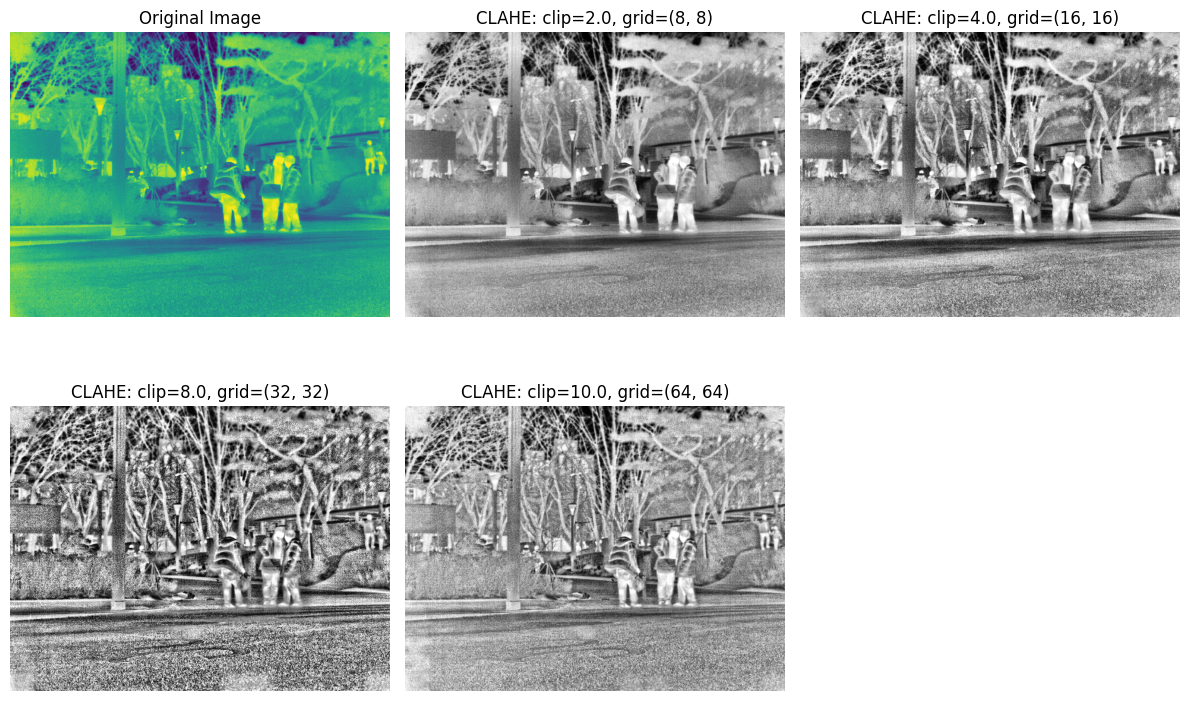

In [45]:
import albumentations as A
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# 백엔드 설정: Jupyter 환경에서 시각화 문제 해결을 위해 필요할 수 있음
%matplotlib inline

# CLAHE 적용 함수
def apply_clahe(image_path, clip_limit=2.0, tile_grid_size=(8, 8)):
    # CLAHE 설정
    transform = A.Compose([
        A.CLAHE(clip_limit=clip_limit, tile_grid_size=tile_grid_size, p=1.0)  # p=1.0으로 100% 적용
    ])
    
    # 이미지 불러오기
    image = np.array(Image.open(image_path))
    
    # CLAHE 적용
    transformed = transform(image=image)
    clahe_image = transformed['image']
    
    return clahe_image

# 시각화 함수
def visualize_clahe_effects(image_path, clip_limits, tile_grid_sizes):
    plt.figure(figsize=(12, 8))

    # 원본 이미지 표시
    image = np.array(Image.open(image_path))  # Pillow 이미지를 numpy로 변환
    plt.subplot(2, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # 다양한 CLAHE 설정 적용하여 시각화
    for i, (clip_limit, tile_grid_size) in enumerate(zip(clip_limits, tile_grid_sizes)):
        clahe_image = apply_clahe(image_path, clip_limit=clip_limit, tile_grid_size=tile_grid_size)
        
        # 이미지가 uint8 형식으로 변환되었는지 확인 (matplotlib에서 시각화를 위해 필요)
        clahe_image = clahe_image.astype(np.uint8)
        
        plt.subplot(2, 3, i + 2)
        plt.imshow(clahe_image, cmap='gray')
        plt.title(f'CLAHE: clip={clip_limit}, grid={tile_grid_size}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 입력 이미지 경로
image_path = "C:/Users/kimin/YOLO/dataset/train/images/train_971.png"

# 실험할 CLAHE 설정들
clip_limits = [2.0, 4.0, 8.0, 10.0]  # 대비 클립 제한 값
tile_grid_sizes = [(8, 8), (16, 16), (32, 32), (64, 64)]  # 타일 크기

# CLAHE 설정에 따른 이미지 변화 시각화
visualize_clahe_effects(image_path, clip_limits, tile_grid_sizes)


In [47]:
from ultralytics import YOLO

# Load a model
#model = YOLO('yolov10n.yaml')  # build a new model from YAML
#model = YOLO("C:/Users/kimin/YOLO/yolov8s.pt")  # load a pretrained model (recommended for training)
#model = YOLO('yolov8n.yaml').load('yolov8n.pt')  # build from YAML and transfer weights

data_yaml = 'C:/Users/kimin/YOLO/dataset/text file/dataset.yaml'  # 데이터셋 yaml 파일 경로

# Train the model
results = model.train(data=data_yaml, 
                      epochs=30, 
                      imgsz=640, 
                      device=0, 
                      lr0=1e-4,
                      augment=True,
                      )

SyntaxError: '[31m[1moverrides[0m' is not a valid YOLO argument. 

    Arguments received: ['yolo', '--f=c:\\Users\\kimin\\AppData\\Roaming\\jupyter\\runtime\\kernel-v325e7821b28b2121b7c3b66437d7b1c3ac82d4b5e.json']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of {'segment', 'obb', 'pose', 'classify', 'detect'}
                MODE (required) is one of {'train', 'val', 'track', 'predict', 'benchmark', 'export'}
                ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
                    See all ARGS at https://docs.ultralytics.com/usage/cfg or with 'yolo cfg'

    1. Train a detection model for 10 epochs with an initial learning_rate of 0.01
        yolo train data=coco8.yaml model=yolov8n.pt epochs=10 lr0=0.01

    2. Predict a YouTube video using a pretrained segmentation model at image size 320:
        yolo predict model=yolov8n-seg.pt source='https://youtu.be/LNwODJXcvt4' imgsz=320

    3. Val a pretrained detection model at batch-size 1 and image size 640:
        yolo val model=yolov8n.pt data=coco8.yaml batch=1 imgsz=640

    4. Export a YOLOv8n classification model to ONNX format at image size 224 by 128 (no TASK required)
        yolo export model=yolov8n-cls.pt format=onnx imgsz=224,128

    5. Explore your datasets using semantic search and SQL with a simple GUI powered by Ultralytics Explorer API
        yolo explorer data=data.yaml model=yolov8n.pt
    
    6. Streamlit real-time webcam inference GUI
        yolo streamlit-predict
        
    7. Run special commands:
        yolo help
        yolo checks
        yolo version
        yolo settings
        yolo copy-cfg
        yolo cfg

    Docs: https://docs.ultralytics.com
    Community: https://community.ultralytics.com
    GitHub: https://github.com/ultralytics/ultralytics
     (<string>)

In [18]:
!pip show ultralytics
!pip install ultralytics --upgrade

Name: ultralytics
Version: 8.0.228
Summary: Ultralytics YOLOv8 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: https://github.com/ultralytics/ultralytics
Author: Ultralytics
Author-email: hello@ultralytics.com
License: AGPL-3.0
Location: c:\users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages
Requires: matplotlib, numpy, opencv-python, pandas, pillow, psutil, py-cpuinfo, pyyaml, requests, scipy, seaborn, thop, torch, torchvision, tqdm
Required-by: 
     ---------------------------------------- 0.0/41.3 kB ? eta -:--:--
     -------------------------------------- 41.3/41.3 kB 661.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/869.1 kB ? eta -:--:--
   ---------------------- ---------------- 491.5/869.1 kB 10.5 MB/s eta 0:00:01
   --------------------------------------- 869.1/869.1 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: ultralytics
    Found existing installation: ultra

## Inference Part (YOLOv8n.pt - best model)

### 3. Predict test_open dataset

In [37]:
from ultralytics import YOLO
import os


model = YOLO("C:/Users/kimin/HSC/runs/detect/train5/weights/best.pt") # 원하는 모델

results = model.predict("C:/Users/kimin/HSC/dataset/test_open/", save=True, conf=0.15)

# 결과를 저장할 폴더 경로 설정
save_dir = "C:/Users/kimin/YOLO/dataset/results/result_3"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 결과를 txt 파일로 저장
for result in results:
    # 이미지 파일명 추출
    image_name = os.path.splitext(os.path.basename(result.path))[0]
    
    # 저장할 txt 파일 경로 설정
    txt_path = os.path.join(save_dir, f"{image_name}.txt")
    
    with open(txt_path, 'w') as f:
        # 각 예측된 객체의 정보를 txt에 기록
        for box in result.boxes:
            class_id = int(box.cls)  # 클래스 ID
            confidence = box.conf.item()  # 신뢰도
            x1, y1, x2, y2 = box.xyxy[0].tolist()  # 바운딩 박스 좌표 (좌상단 x1, y1, 우하단 x2, y2)

            # width와 height 계산
            width = x2 - x1
            height = y2 - y1

            # 원하는 형식: class_id x1 y1 width height confidence
            f.write(f"{class_id} {x1:.2f} {y1:.2f} {width:.2f} {height:.2f} {confidence:.2f}\n")

print(f"결과가 {save_dir} 폴더에 저장되었습니다.")



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1636 C:\Users\kimin\HSC\dataset\test_open\test_open_0.png: 480x640 1 car, 1 truck, 35.1ms
image 2/1636 C:\Users\kimin\HSC\dataset\test_open\test_open_1.png: 480x640 1 car, 26.0ms
image 3/1636 C:\Users\kimin\HSC\dataset\test_open\test_open_10.png: 480x640 (no detections), 34.5ms
image 4/1636 C:\Users\kimin\HSC\dataset\test_open\test_open_100.png: 480x640 1 person, 2 cars, 7.0ms
image 5/1636 C:\Users\kimin\HSC\dataset\test_open\test_open_1000.png: 

### 4. Convert Prediction file results

In [38]:
import os
import json
import re

# 결과가 저장된 폴더 경로 (이 폴더에서 txt 파일을 읽어옵니다)
save_dir = "C:/Users/kimin/YOLO/dataset/results/result_3"

# 최종 결과를 저장할 리스트
output_data = []

# 자연 정렬을 위한 함수 정의
def natural_sort_key(file_name):
    # 숫자가 포함된 부분을 기준으로 정렬
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', file_name)]

# 결과 폴더 내 모든 txt 파일을 자연 정렬하여 읽기
txt_files = sorted([f for f in os.listdir(save_dir) if f.endswith(".txt")], key=natural_sort_key)

# txt 파일에서 데이터를 읽어와 결과 리스트 생성
for txt_file in txt_files:
    # 파일명에서 확장자 제거하여 image_id 생성
    image_id = os.path.splitext(txt_file)[0]
    
    # txt 파일 경로
    txt_path = os.path.join(save_dir, txt_file)
    
    # txt 파일 읽기
    with open(txt_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            # 각 라인의 데이터를 분해 (class_id, x1, y1, width, height, confidence)
            parts = line.strip().split()
            category_id = int(parts[0])
            x1 = float(parts[1])
            y1 = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])
            score = float(parts[5])

            # 결과를 원하는 형식으로 리스트에 추가
            output_data.append({
                "image_id": image_id,
                "category_id": category_id,
                "bbox": [round(x1, 2), round(y1, 2), round(width, 2), round(height, 2)],
                "score": round(score, 5)
            })

# 결과를 저장할 경로 지정 (다른 폴더에 저장하도록 경로 설정)
output_dir = "C:/Users/kimin/YOLO/dataset/sub_file"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 결과 파일 이름 설정 (중복 확인 후 새로운 파일 이름 생성)
base_filename = "result_3"
extension = ".txt"
result_path = os.path.join(output_dir, base_filename + extension)

# 파일이 이미 존재하는지 확인하고, 숫자를 추가하여 중복 방지
counter = 1
while os.path.exists(result_path):
    result_path = os.path.join(output_dir, f"{base_filename}_{counter}{extension}")
    counter += 1

# 결과를 result.txt 또는 다른 이름으로 저장
with open(result_path, 'w') as result_file:
    result_file.write(json.dumps(output_data, indent=4))

print(f"결과가 {result_path}에 저장되었습니다.")

결과가 C:/Users/kimin/YOLO/dataset/sub_file\result_3.txt에 저장되었습니다.


In [4]:
!pip freeze -r requirements.txt

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages\pip\_internal\cli\base_command.py", line 180, in exc_logging_wrapper
    status = run_func(*args)
  File "C:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages\pip\_internal\commands\freeze.py", line 98, in run
    for line in freeze(
  File "C:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages\pip\_internal\operations\freeze.py", line 43, in freeze
    req = FrozenRequirement.from_dist(dist)
  File "C:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages\pip\_internal\operations\freeze.py", line 238, in from_dist
    req, comments = _get_editable_info(dist)
  File "C:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages\pip\_internal\operations\freeze.py", line 165, in _get_editable_info
    vcs_backend = vcs.get_backend_for_dir(location)
  File "C:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-p